In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import r2_score

from scipy.optimize import nnls, lsq_linear, least_squares

%matplotlib inline

In [2]:
# random state
rs = 4

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [3]:
# Spain, UK, Italy, Germany...
cc_dict = {
    'ARG': 'Argentina', 'AUS': 'Australia',  
    'CHN': 'China',     'CZE': 'Czechia',    
    'EGY': 'Egypt',     'FIN': 'Finland',
    'HND': 'Honduras',  'IND': 'India',
    'JPN': 'Japan',     'NOR': 'Norway',
    'RUS': 'Russia',    'SWE': 'Sweden',
    'THA': 'Thailand',  'USA': 'US'
}

# cc_dict = {
#     'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
#     'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
#     'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
#     'POL': 'Poland',       'SSD': 'South Sudan', 'TUN': 'Tunisia',
#     'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
# }

pop_dict = { # 2020 population
    'ARG': 45195774,   'AUS': 25499884, 
    'CHN': 1439323776, 'CZE': 10708981,   
    'EGY': 102334404,  'FIN': 5540720,  
    'HND': 9904607,    'IND': 1380004385, 
    'JPN': 126476461,  'NOR': 5421241,  
    'RUS': 145934462,  'SWE': 10099265,
    'THA': 69799978,   'USA': 331002651
}

# pop_dict = {
#     'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
#     'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
#     'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
#     'POL': 37846611,  'SSD': 11193725, 'TUN': 11818619,
#     'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
# }

# pd.read_html('https://worldpopulationreview.com/countries', header=0, index_col=1)[0].reindex(cc_dict.values())

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [4]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [5]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(279, 646)

In [6]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(279, 646)

In [7]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(264, 646)

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [8]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,680,710,725,742,749,765,782,798,817,849,874,893,906,928,959,1011,1063,1101,1129,1162,1190,1231,1271,1296,1326,1358,1386,1437,1483,1518,1538,1571,1588,1612,1636,1664,1677,1701,1710,1719
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,48341,49611,50919,51986,52922,53898,54919,55962,56988,57983,58931,59709,60561,61420,62353,63212,64014,64668,65279,65876,66456,67024,67669,68246,68712,69205,69552,69993,70391,70781,71099,71399,71658,71923,72202,72560,72899,73212,73500,73785
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,204,204,204,204,206,206,206,208,208,208,208,209,209,210,211,211,212,212,212,212,212,212,213,214,214,215,215,216,222,222,224,225,225,225,225,225,225,225,225,225
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,2013,2014,2015,2015,2017,2018,2019,2021,2021,2022,2022,2022,2028,2029,2035,2039,2042,2043,2046,2048,2051,2056,2056,2059,2062,2063,2067,2067,2067,2068,2071,2071,2071,2071,2072,2077,2082,2082,2082,2082
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,896,898,898,898,898,898,898,899,900,900,900,901,901,901,901,901,902,904,905,906,907,907,907,908,909,910,913,914,914,914,914,915,915,915,916,916,917,917,917,918
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,236,236,236,236,236,236,236,236,236,236,236,237,237,237,237,237,237,237,237,237,237,237,237
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,26942,27439,27968,28456,29008,29596,30216,30961,31679,32515,33294,33967,34975,35904,37333,38476,39952,41128,42505,44251,45664,47266,49104,51012,52902,54470,55936,57470,59763,61869,63836,65674,67457,69206,70998,73151,75340,76915,78821,80224
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1089,1089,1092,1092,1093,1094,1094,1094,1094,1095,1095,1095,1096,1096,1096,1096,1096,1096,1099,1109,1110,1110,1110,1110,1110,1110,1110,1111,1111,1111,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112


In [9]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15155,15177,15202,15221,15249,15274,15305,15305,15351,15370,15405,15416,15432,15448,15472,15500,15514,15533,15536,15543,15560,15578,15587,15605,15626,15626,15645,15663,15663,15692,15702,15715,15720,15732,15746,15765,15779,15790,15800,15807
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1949,1956,1962,1969,1972,1974,1980,1988,1998,2003,2010,2019,2045,2068,2083,2096,2116,2126,2141,2157,2168,2184,2204,2217,2217,2235,2257,2274,2290,2306,2312,2325,2335,2341,2353,2365,2373,2379,2383,2388
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15867,15925,15975,16031,16056,16086,16150,16216,16254,16303,16339,16373,16383,16428,16465,16500,16556,16592,16609,16618,16650,16684,16704,16742,16777,16787,16804,16837,16866,16885,16899,16921,16934,16936,16955,16972,16984,16998,17002,17011
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4021,4053,4070,4070,4091,4117,4146,4161,4178,4197,4213,4213,4235,4263,4263,4283,4291,4307,4321,4342,4342,4355,4386,4395,4395,4403,4403,4420,4431,4438,4439,4444,4444,4448,4456,4467,4468,4472,4478,4478
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1977016,1979114,1981252,1983252,1984915,1986241,1987905,1989805,1991628,1993309,1994901,1996498,1997885,1999592,2001347,2003050,2004763,2006421,2008024,2009648,2011530,2013425,2016171,2018932,2021433,2023691,2026402,2029289,2033005,2036628,2040337,2044039,2047711,2051065,2054960,2059534,2064729,2070597,2076273,2082563


Canada does not have recovery data available at province-level.

In [10]:
jhu_cases['Country/Region'].value_counts().head(9)

China                   34
Canada                  16
United Kingdom          12
France                  12
Australia                8
Netherlands              5
Denmark                  3
New Zealand              2
Summer Olympics 2020     1
Name: Country/Region, dtype: int64

In [11]:
jhu_death['Country/Region'].value_counts().head(9)

China                   34
Canada                  16
United Kingdom          12
France                  12
Australia                8
Netherlands              5
Denmark                  3
New Zealand              2
Summer Olympics 2020     1
Name: Country/Region, dtype: int64

In [12]:
jhu_recov['Country/Region'].value_counts().head(9)

China                   34
United Kingdom          12
France                  12
Australia                8
Netherlands              5
Denmark                  3
New Zealand              2
Diamond Princess         1
Summer Olympics 2020     1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [13]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (275, 643)
deaths shape: (275, 643)
recoveries shape: (260, 643)


In [14]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (642, 195)
deaths shape: (642, 195)
recoveries shape: (642, 195)


Create separate dataframes containing data on countries of interest only. Apply a smoothing average to the curves. Use them to compute further variables (compartments) needed to represent the compartmental model.

In [15]:
window = 7

In [16]:
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_cases

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000,879.250000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.750000e+00,1.500000e+00
2020-01-23,0.000000e+00,0.800000,1118.400000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.400000e+00,0.000000,0.000000e+00,0.000000e+00,5.400000e+00,2.200000e+00
2020-01-24,0.000000e+00,1.500000,1411.500000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.666667e+00,0.000000,0.000000e+00,0.000000e+00,5.833333e+00,2.666667e+00
2020-01-25,0.000000e+00,2.000000,1996.857143,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,3.285714e+00,0.000000,0.000000e+00,0.000000e+00,7.000000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.857143,2788.142857,0.000000e+00,0.000000,0.142857,0.000000,0.000000e+00,4.000000e+00,0.000000,0.000000e+00,0.000000e+00,8.428571e+00,3.714286e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,5.276145e+06,151914.000000,109024.142857,1.716335e+06,321091.142857,152001.285714,373153.857143,3.412720e+07,1.716483e+06,198209.142857,7.972359e+06,1.164150e+06,1.812343e+06,4.520961e+07
2021-10-21,5.277261e+06,154062.428571,109063.571429,1.719268e+06,321971.571429,152466.857143,373435.142857,3.414269e+07,1.716795e+06,198804.285714,8.006998e+06,1.164730e+06,1.821883e+06,4.528246e+07
2021-10-22,5.277894e+06,155189.333333,109083.000000,1.720860e+06,322410.333333,152676.833333,373644.500000,3.415075e+07,1.716970e+06,199122.333333,8.024170e+06,1.165196e+06,1.826561e+06,4.532105e+07
2021-10-23,5.278519e+06,156347.600000,109103.800000,1.722583e+06,322851.000000,152854.800000,373732.200000,3.415910e+07,1.717141e+06,199446.000000,8.041645e+06,1.165517e+06,1.831287e+06,4.535883e+07


In [17]:
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,31.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,40.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,53.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,69.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,115759.285714,1591.142857,4849.000000,30575.857143,18105.142857,1130.000000,10144.000000,453032.142857,18162.571429,889.428571,222345.142857,14976.000000,18483.571429,730547.714286
2021-10-21,115782.142857,1606.142857,4849.000000,30585.857143,18150.142857,1133.285714,10157.571429,453378.142857,18176.142857,890.857143,223362.571429,14981.285714,18552.428571,732237.857143
2021-10-22,115795.166667,1614.166667,4849.000000,30591.166667,18172.666667,1135.500000,10167.833333,453532.166667,18184.000000,892.000000,223869.166667,14985.500000,18588.500000,733305.000000
2021-10-23,115806.800000,1621.600000,4849.000000,30595.400000,18195.600000,1137.000000,10172.000000,453708.400000,18189.600000,893.600000,224380.200000,14990.000000,18624.800000,734327.600000


In [18]:
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.0,0.0,33.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.500000,0.0
2020-01-23,0.0,0.0,36.400000,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,3.200000,0.0
2020-01-24,0.0,0.0,40.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,3.666667,0.0
2020-01-25,0.0,0.0,48.714286,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,0.0,4.000000,0.0
2020-01-26,0.0,0.0,61.857143,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,0.0,4.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2021-10-21,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2021-10-22,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2021-10-23,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [19]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [20]:
R = cum_deaths + cum_recoveries
R

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000
2020-01-23,0.000000,0.000000,68.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,3.200000,0.000000
2020-01-24,0.000000,0.000000,80.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,3.666667,0.000000
2020-01-25,0.000000,0.000000,101.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,4.000000,0.000000
2020-01-26,0.000000,0.000000,131.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,4.571429,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,115759.285714,1591.142857,4849.000000,30575.857143,18105.142857,1130.000000,10144.000000,453032.142857,18162.571429,889.428571,222345.142857,14976.000000,18483.571429,730547.714286
2021-10-21,115782.142857,1606.142857,4849.000000,30585.857143,18150.142857,1133.285714,10157.571429,453378.142857,18176.142857,890.857143,223362.571429,14981.285714,18552.428571,732237.857143
2021-10-22,115795.166667,1614.166667,4849.000000,30591.166667,18172.666667,1135.500000,10167.833333,453532.166667,18184.000000,892.000000,223869.166667,14985.500000,18588.500000,733305.000000
2021-10-23,115806.800000,1621.600000,4849.000000,30595.400000,18195.600000,1137.000000,10172.000000,453708.400000,18189.600000,893.600000,224380.200000,14990.000000,18624.800000,734327.600000


In [21]:
I = cum_cases - R
I

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000,820.250000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.250000e+00,1.500000e+00
2020-01-23,0.000000e+00,0.800000,1050.200000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.200000e+00,0.000000,0.000000e+00,0.000000e+00,2.200000e+00,2.200000e+00
2020-01-24,0.000000e+00,1.500000,1331.333333,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.333333e+00,0.000000,0.000000e+00,0.000000e+00,2.166667e+00,2.666667e+00
2020-01-25,0.000000e+00,2.000000,1895.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.857143e+00,0.000000,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.857143,2656.571429,0.000000e+00,0.000000,0.142857,0.000000,0.000000e+00,3.428571e+00,0.000000,0.000000e+00,0.000000e+00,3.857143e+00,3.714286e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,5.160386e+06,150322.857143,104175.142857,1.685759e+06,302986.000000,150871.285714,363009.857143,3.367417e+07,1.698321e+06,197319.714286,7.750014e+06,1.149174e+06,1.793859e+06,4.447906e+07
2021-10-21,5.161478e+06,152456.285714,104214.571429,1.688683e+06,303821.428571,151333.571429,363277.571429,3.368932e+07,1.698619e+06,197913.428571,7.783635e+06,1.149749e+06,1.803330e+06,4.455022e+07
2021-10-22,5.162098e+06,153575.166667,104234.000000,1.690269e+06,304237.666667,151541.333333,363476.666667,3.369722e+07,1.698786e+06,198230.333333,7.800301e+06,1.150211e+06,1.807973e+06,4.458774e+07
2021-10-23,5.162712e+06,154726.000000,104254.800000,1.691988e+06,304655.400000,151717.800000,363560.200000,3.370539e+07,1.698951e+06,198552.400000,7.817265e+06,1.150527e+06,1.812662e+06,4.462450e+07


In [22]:
S = pop_dict.values() - cum_cases
S

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,4.519577e+07,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-23,4.519577e+07,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-24,4.519577e+07,2.549988e+07,1.439322e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-25,4.519577e+07,2.549988e+07,1.439322e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-26,4.519577e+07,2.549988e+07,1.439321e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,3.991963e+07,2.534797e+07,1.439215e+09,8.992646e+06,1.020133e+08,5.388719e+06,9.531453e+06,1.345877e+09,1.247600e+08,5.223032e+06,1.379621e+08,8.935115e+06,6.798764e+07,2.857930e+08
2021-10-21,3.991851e+07,2.534582e+07,1.439215e+09,8.989713e+06,1.020124e+08,5.388253e+06,9.531172e+06,1.345862e+09,1.247597e+08,5.222437e+06,1.379275e+08,8.934535e+06,6.797810e+07,2.857202e+08
2021-10-22,3.991788e+07,2.534469e+07,1.439215e+09,8.988120e+06,1.020120e+08,5.388043e+06,9.530962e+06,1.345854e+09,1.247595e+08,5.222119e+06,1.379103e+08,8.934068e+06,6.797342e+07,2.856816e+08
2021-10-23,3.991726e+07,2.534354e+07,1.439215e+09,8.986398e+06,1.020116e+08,5.387865e+06,9.530875e+06,1.345845e+09,1.247593e+08,5.221795e+06,1.378928e+08,8.933748e+06,6.796869e+07,2.856438e+08


In [23]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

In [24]:
r_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,4.099147e-08,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.581663e-08,0.000000
max,0.103704,0.000982,7.225149e-05,0.156032,0.002417,0.00848,0.010988,0.022669,0.006756,0.003467,0.039143,0.001484,4.567848e-04,0.019045


In [25]:
i_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,7.324868e-08,0.000000,0.000000,0.000000,0.000000,0.00000,1.581322e-08,0.000000,0.000000,0.000000,3.104108e-08,4.531686e-09
max,0.114244,0.006111,7.245052e-05,0.158162,0.002981,0.027416,0.036719,0.02443,1.343415e-02,0.036684,0.053686,0.113949,2.603849e-02,1.349180e-01


In [26]:
s_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.883194,0.993826,0.999924,0.838981,0.996841,0.972378,0.962254,0.975241,0.986422,0.963151,0.944773,0.884566,0.973694,0.862861
max,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [27]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,-14.377830,0.000000,0.000000,0.000000,0.000000,0.000000,-17.962420,0.000000,0.000000,0.000000,-17.250214,-19.212172
2020-01-23,0.000000,-17.277328,-14.130703,0.000000,0.000000,0.000000,0.000000,0.000000,-17.867109,0.000000,0.000000,0.000000,-17.272687,-18.829180
2020-01-24,0.000000,-16.648719,-13.893503,0.000000,0.000000,0.000000,0.000000,0.000000,-17.808269,0.000000,0.000000,0.000000,-17.287954,-18.636808
2020-01-25,0.000000,-16.361037,-13.540465,0.000000,0.000000,0.000000,0.000000,0.000000,-17.605745,0.000000,0.000000,0.000000,-16.962532,-18.519025
2020-01-26,0.000000,-16.004362,-13.202648,0.000000,0.000000,-17.473545,0.000000,0.000000,-17.423423,0.000000,0.000000,0.000000,-16.711218,-18.305451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,-2.169992,-5.133644,-9.533610,-1.848867,-5.822315,-3.603453,-3.306325,-3.713111,-4.310416,-3.313255,-2.935463,-2.173419,-3.661265,-2.007108
2021-10-21,-2.169781,-5.119551,-9.533232,-1.847134,-5.819561,-3.600393,-3.305588,-3.712661,-4.310241,-3.310250,-2.931134,-2.172919,-3.655999,-2.005509
2021-10-22,-2.169660,-5.112239,-9.533046,-1.846195,-5.818192,-3.599021,-3.305040,-3.712427,-4.310142,-3.308650,-2.928995,-2.172517,-3.653428,-2.004667
2021-10-23,-2.169542,-5.104773,-9.532846,-1.845179,-5.816820,-3.597858,-3.304810,-3.712184,-4.310045,-3.307027,-2.926823,-2.172243,-3.650837,-2.003843


In [28]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,-17.277328,0.247127,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,0.000000,0.000000,0.000000,-0.022473,0.382992
2020-01-24,0.000000,0.628609,0.237200,0.000000,0.000000,0.000000,0.000000,0.000000,0.058841,0.000000,0.000000,0.000000,-0.015267,0.192372
2020-01-25,0.000000,0.287682,0.353038,0.000000,0.000000,0.000000,0.000000,0.000000,0.202524,0.000000,0.000000,0.000000,0.325422,0.117783
2020-01-26,0.000000,0.356675,0.337818,0.000000,0.000000,-17.473545,0.000000,0.000000,0.182322,0.000000,0.000000,0.000000,0.251314,0.213574
2020-01-27,0.000000,0.300105,0.328822,0.000000,0.000000,0.693147,0.000000,-22.991263,0.287682,0.000000,0.000000,0.000000,0.169899,0.175891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0.000208,0.014642,0.000362,0.001600,0.002754,0.003069,0.000738,0.000448,0.000194,0.002857,0.004326,0.000501,0.005414,0.001603
2021-10-21,0.000212,0.014093,0.000378,0.001733,0.002754,0.003059,0.000737,0.000450,0.000176,0.003004,0.004329,0.000500,0.005266,0.001598
2021-10-22,0.000120,0.007312,0.000186,0.000939,0.001369,0.001372,0.000548,0.000234,0.000098,0.001600,0.002139,0.000402,0.002571,0.000842
2021-10-23,0.000119,0.007466,0.000200,0.001016,0.001372,0.001164,0.000230,0.000243,0.000097,0.001623,0.002172,0.000275,0.002590,0.000824


### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{s}=\frac{(\log{i_2}-\log{i_1})+\gamma}{s}$. An alternative path to the transmission rate is $\beta=\frac{\log{s_1}-\log{s_2}}{i}$. This has the advantage of not having to deal with values $\log0$, which we were classifying as $0$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [29]:
# the alternative formula
# log_s = np.log(s_prop)
# diff_log = log_s[:-1].values - log_s[1:] # same index as other variables
# beta = diff_log / i_prop
# beta

In [30]:
dr_dt = r_prop[1:] - r_prop[:-1].values # different index
dr_dt

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000e+00,0.000000e+00,6.391891e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.581322e-09,0.000000e+00,0.000000,0.000000e+00,1.002866e-08,0.000000
2020-01-24,0.000000e+00,0.000000e+00,8.314089e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.054215e-09,0.000000e+00,0.000000,0.000000e+00,6.685771e-09,0.000000
2020-01-25,0.000000e+00,0.000000e+00,1.506991e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.530104e-10,0.000000e+00,0.000000,0.000000e+00,4.775551e-09,0.000000
2020-01-26,0.000000e+00,0.000000e+00,2.064462e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.129516e-09,0.000000e+00,0.000000,0.000000e+00,8.186658e-09,0.000000
2020-01-27,0.000000e+00,1.120453e-08,2.560726e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.129516e-09,0.000000e+00,0.000000,0.000000e+00,1.023332e-08,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,5.057363e-07,5.882380e-07,0.000000e+00,9.204557e-07,4.411308e-07,5.930122e-07,1.370214e-06,2.220490e-07,1.129516e-07,2.635137e-07,0.000007,5.233761e-07,1.011052e-06,0.000005
2021-10-21,5.057363e-07,5.882380e-07,0.000000e+00,9.337957e-07,4.397348e-07,5.930122e-07,1.370214e-06,2.507238e-07,1.073040e-07,2.635137e-07,0.000007,5.233761e-07,9.864923e-07,0.000005
2021-10-22,2.881643e-07,3.146606e-07,0.000000e+00,4.958010e-07,2.201001e-07,3.996386e-07,1.036074e-06,1.116111e-07,6.212336e-08,2.108110e-07,0.000003,4.172864e-07,5.167828e-07,0.000003
2021-10-23,2.573987e-07,2.915046e-07,0.000000e+00,3.953068e-07,2.241019e-07,2.707229e-07,4.206797e-07,1.277049e-07,4.427701e-08,2.951354e-07,0.000004,4.455770e-07,5.200575e-07,0.000003


In [31]:
gamma = dr_dt / i_prop[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.008760,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000e+00,0.000000,0.000000,0.318182,0.000000
2020-01-24,0.000000,0.000000,0.008988,0.000000,0.000000,0.000000,0.000000,0.000000,0.057143,0.000000e+00,0.000000,0.000000,0.215385,0.000000
2020-01-25,0.000000,0.000000,0.011446,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000e+00,0.000000,0.000000,0.111111,0.000000
2020-01-26,0.000000,0.000000,0.011185,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000e+00,0.000000,0.000000,0.148148,0.000000
2020-01-27,0.000000,0.074074,0.009986,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000e+00,0.000000,0.000000,0.156250,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0.000004,0.000100,0.000000,0.000006,0.000149,0.000022,0.000037,0.000009,0.000008,7.239882e-06,0.000130,0.000005,0.000039,0.000039
2021-10-21,0.000004,0.000098,0.000000,0.000006,0.000148,0.000022,0.000037,0.000010,0.000008,7.218163e-06,0.000131,0.000005,0.000038,0.000038
2021-10-22,0.000003,0.000052,0.000000,0.000003,0.000074,0.000015,0.000028,0.000005,0.000005,5.765299e-06,0.000065,0.000004,0.000020,0.000024
2021-10-23,0.000002,0.000048,0.000000,0.000003,0.000075,0.000010,0.000011,0.000005,0.000003,8.058326e-06,0.000065,0.000004,0.000020,0.000023


In [32]:
beta = (gr + gamma) / s_prop[1:]
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,-17.277329,0.255887,0.000000,0.000000,0.000000,0.000000,0.000000,0.186219,0.000000,0.000000,0.000000,0.295709,0.382992
2020-01-24,0.000000,0.628609,0.246189,0.000000,0.000000,0.000000,0.000000,0.000000,0.115983,0.000000,0.000000,0.000000,0.200117,0.192372
2020-01-25,0.000000,0.287682,0.364485,0.000000,0.000000,0.000000,0.000000,0.000000,0.235858,0.000000,0.000000,0.000000,0.436534,0.117783
2020-01-26,0.000000,0.356675,0.349003,0.000000,0.000000,-17.473546,0.000000,0.000000,0.223988,0.000000,0.000000,0.000000,0.399463,0.213574
2020-01-27,0.000000,0.374179,0.338809,0.000000,0.000000,0.693147,0.000000,-22.991263,0.318932,0.000000,0.000000,0.000000,0.326149,0.175891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0.000240,0.014830,0.000362,0.001912,0.002912,0.003178,0.000805,0.000469,0.000205,0.002973,0.004713,0.000571,0.005599,0.001901
2021-10-21,0.000245,0.014277,0.000378,0.002071,0.002911,0.003168,0.000805,0.000472,0.000186,0.003126,0.004718,0.000571,0.005446,0.001896
2021-10-22,0.000139,0.007410,0.000186,0.001123,0.001448,0.001426,0.000599,0.000245,0.000104,0.001667,0.002332,0.000458,0.002661,0.001003
2021-10-23,0.000137,0.007560,0.000200,0.001214,0.001452,0.001207,0.000251,0.000254,0.000102,0.001694,0.002368,0.000315,0.002681,0.000981


## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment- and some health system-related measures are considered.

In [33]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[37:], axis=1, inplace=True)    # indexes and extra

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207168 entries, 0 to 207167
Data columns (total 37 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            207168 non-null  object        
 1   CountryCode                            207168 non-null  object        
 2   RegionName                             83664 non-null   object        
 3   RegionCode                             83664 non-null   object        
 4   Jurisdiction                           207168 non-null  object        
 5   Date                                   207168 non-null  datetime64[ns]
 6   C1_School closing                      200235 non-null  float64       
 7   C1_Flag                                163288 non-null  float64       
 8   C2_Workplace closing                   200146 non-null  float64       
 9   C2_Flag                                155292 no

Policy implementation is available at state level in some countries.

In [34]:
oxcgrt_sub = oxcgrt[oxcgrt['Jurisdiction'] == 'STATE_TOTAL'].copy()
oxcgrt_sub

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
15272,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
15273,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
15274,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
15275,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
15276,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201187,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201188,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201189,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201190,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# region information
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True)

oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']
oxcgrt

,CountryName,CountryCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
0,Aruba,ABW,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
1,Aruba,ABW,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,Aruba,ABW,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
3,Aruba,ABW,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
4,Aruba,ABW,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207163,Zimbabwe,ZWE,NAT_TOTAL,2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207164,Zimbabwe,ZWE,NAT_TOTAL,2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207165,Zimbabwe,ZWE,NAT_TOTAL,2021-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207166,Zimbabwe,ZWE,NAT_TOTAL,2021-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [36]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-10-24 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-10-25 00:00:00


Pivot the data to obtain a different dataset for each policy type indexed by time (date).

In [37]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

CH_X = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

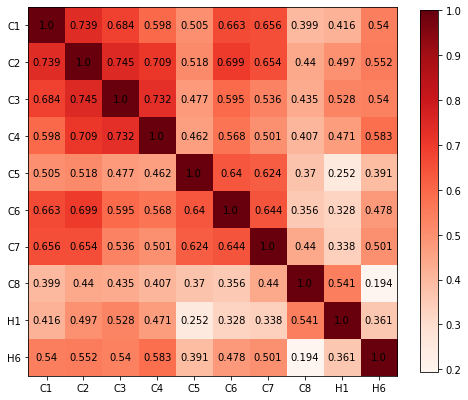

In [38]:
mask = oxcgrt['CountryCode'].isin(cc_dict)
corr = oxcgrt.loc[mask, idch].corr()

# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=corr, cmap='Reds') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# show all ticks...
ax.set_xticks(range(corr.shape[1]))
ax.set_yticks(range(corr.shape[0]))
# ...and label them
[s.split('_')[0] for s in idch]
ax.set_xticklabels([s.split('_')[0] for s in corr.columns])
ax.set_yticklabels([s.split('_')[0] for s in corr.index])
# loop over data dimensions and create text annotations
for i in range(corr.shape[1]):
  for j in range(corr.shape[0]):
    text = ax.text(j, i, round(corr.iloc[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [39]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 72
 - C2: 79
 - C3: 80
 - C4: 92
 - C5: 85
 - C6: 78
 - C7: 79
 - C8: 79
 - H1: 80
 - H6: 78


## Visualizations

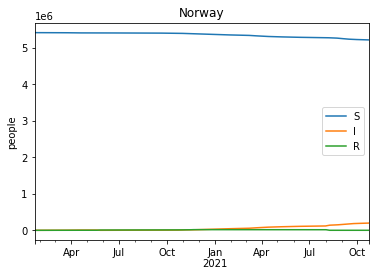

In [40]:
cc_idx = 9
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

In [41]:
print('Missing values (NaN) in the response')
print(' - growth rate:', gr.isna().sum().sum())
print(' - transmission rate:', beta.isna().sum().sum())

Missing values (NaN) in the response
 - growth rate: 0
 - transmission rate: 0


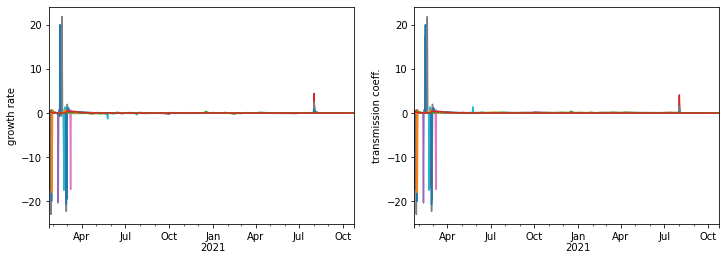

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries present various spikes.

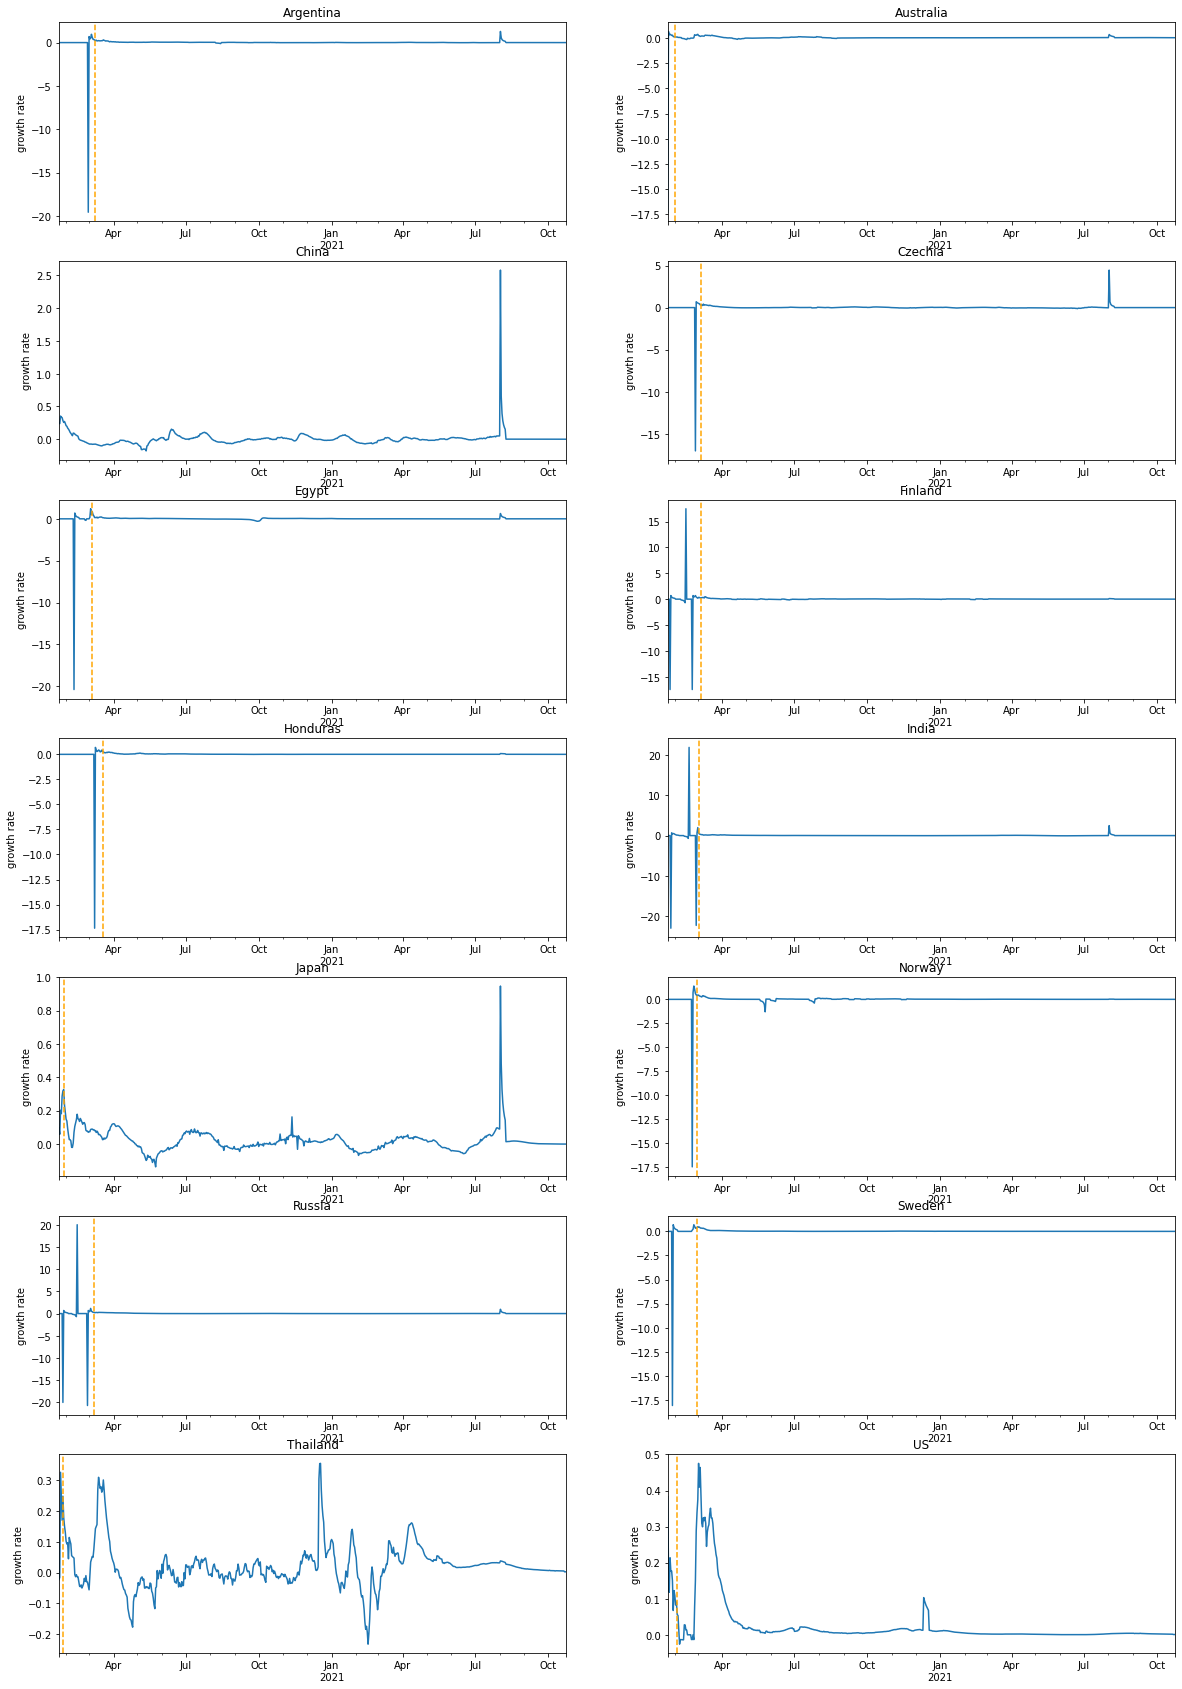

In [43]:
nrows = len(cc_dict) // 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')

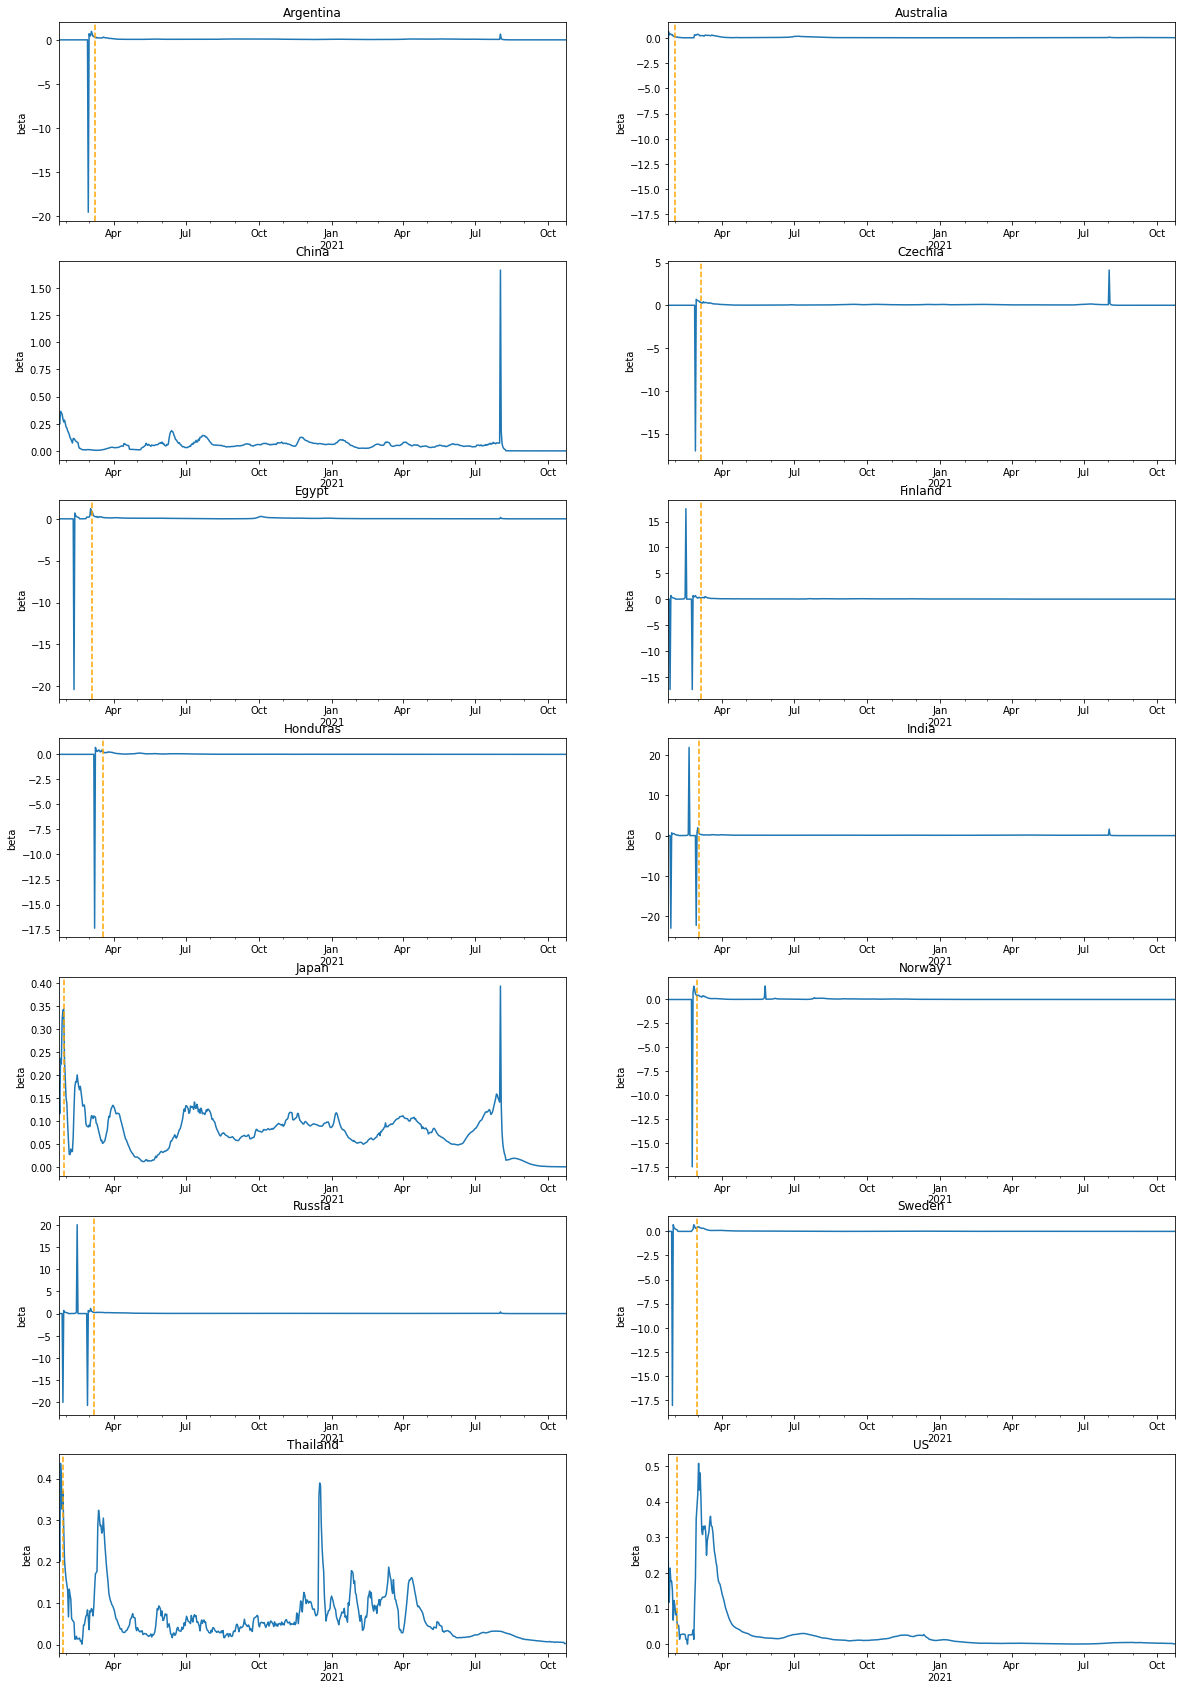

In [44]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')

# Model

Development of the model(s) and results.

## Auxiliar

In [45]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

chx_str = [s.split('_')[0] for s in idch]

In [46]:
# check starting date
ta == beta.index.min()

True

In [47]:
# aux fns
def _get_init_date(iso):
  name = cc_dict[iso]
  t_idx = cum_cases.loc[cum_cases[name] > 25, name].index
  return t_idx.min()

def data_from(iso, t0, t1, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = _get_init_date(iso)
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not t1:
    if not tr:
      raise ValueError('Provide end of time range (either t1 or tr).')
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()

  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: specific for each of the two label types
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_t.fillna(value=0, inplace=True)      # if no previous value available
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # policy combinations
  # poly = PolynomialFeatures(degree=2, interaction_only=True)
  # pol_comb = poly.fit_transform(pol_norm)
  # comb_str = poly.get_feature_names(chx_str)
  # day-of-the-week
  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  # previous 
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = np.append(chx_str, 'prev')
  df = pd.DataFrame(arr, columns=col)

  # label = pd.Series(y_norm[1:], index=y_t[1:].index) # date ref
  
  return df, y_norm[1:]

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(round(score, 3))

## Initial model

Uses the groth rate, $gr=\beta-\gamma$, as label. Conditioned on the restriction $s\rightarrow1$, it reaches a different time range depending on the country.

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [48]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      # to do: filter negative values
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-2.61501137e+25,  8.25683514e-01,  7.83538383e-01, -1.67169917e+25,
       -3.66704324e+24,  8.44134209e-01,  8.16875497e-01,  7.85930771e-01,
        8.02881475e-01,  7.57096552e-01, -1.55842929e+23,  8.25048849e-01,
       -1.62081693e+25,  8.07008633e-01,  7.58454641e-01, -4.25921244e+24,
        8.31699479e-01,  7.87227525e-01,  8.14215690e-01,  7.65267618e-01,
        8.49177665e-01, -1.16115084e+25, -7.84513182e+23,  8.16189084e-01,
       -1.12435535e+20])

In [49]:
cv_arr.mean()

-3.1821402944449594e+24

In [50]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.84848971, 0.81412559, 0.77933396, 0.7988769 , 0.76496125,
       0.85067042, 0.81833284, 0.78167302, 0.79841129, 0.76189207,
       0.83868866, 0.82064276, 0.77586446, 0.79880063, 0.76189605,
       0.8529411 , 0.82358325, 0.77749614, 0.80069831, 0.76324669,
       0.85845506, 0.82533055, 0.78124073, 0.80350276, 0.76612138])

In [51]:
cv_arr.mean()

0.8026110234329668

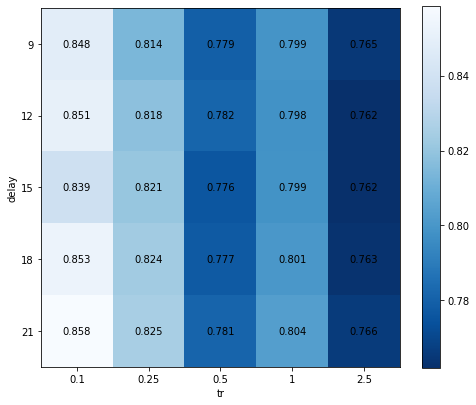

In [52]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [53]:
def initial_model(region, tr=.1, delay=15, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [54]:
coef = []; r_sq = [];
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = initial_model(k)
  coef.append(m_k.coef_[:-1])
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameteres. It is obtained from the training data.

In [55]:
np.asarray(r_sq).mean()

0.7580969532376906

In [56]:
for r_i in r_sq:
  print(round(r_i, 2))

0.94
0.97
-1.62
0.98
0.93
0.9
0.95
0.8
0.95
0.96
0.98
0.99
0.94
0.94


Global effect of each policy.

In [57]:
coef = np.asarray(coef).mean(axis=0)
for string, value in zip(idch, coef):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.013560
Workplace closing                 -> -0.003498
Cancel public events              -> -0.024935
Restrictions on gatherings        -> -0.008347
Close public transport            -> -0.006591
Stay at home requirements         -> -0.003793
Restrictions on internal movement -> -0.024127
International travel controls     -> -0.007509
Public information campaigns      -> -0.042277
Facial Coverings                  -> -0.012603


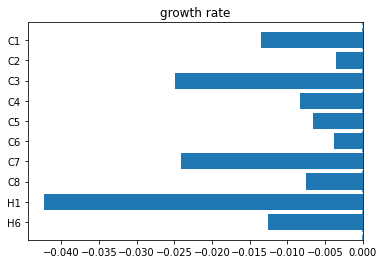

In [58]:
plt.barh(chx_str[::-1], coef[::-1]) # flip order
plt.axvline(ls='--')
plt.title('growth rate')
plt.show()

In [59]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of the model for one country.

In [60]:
idx = 10 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.006861
C2 : -0.017024
C5 : -0.049305
C6 : -0.000000
C7 : -0.047764
H1 : -0.035327
prev : 0.724532

R^2
---
0.976


Visual representation of the model.

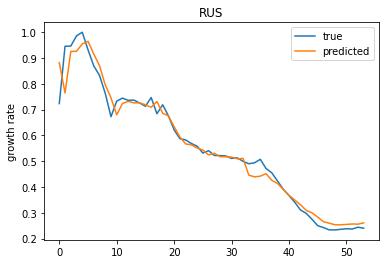

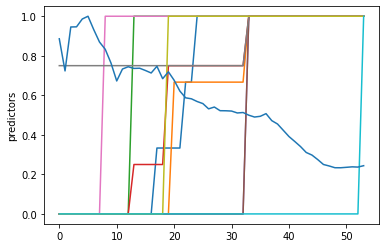


Number of data points: 54
Number of variables: 11


In [61]:
model, X, y = initial_model(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

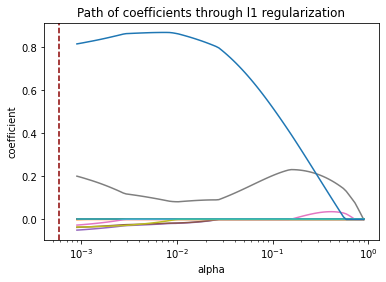

In [62]:
alphas, coefs = model.path(X, y)[:2]
alpha = model.get_params()['alpha']
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(alpha, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

## Transmission model

It uses the transmission rate, $\beta$, as label. The linear function is fitted in thiner time segments.

Parameter grid search.

In [63]:
# mm-dd-yyyy format
t_init = pd.to_datetime('06-01-2020')
t_end = t_init + pd.to_timedelta(60, unit='days')

In [64]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 8.83040968e-01,  8.81350753e-01,  8.81832357e-01,  8.83498145e-01,
       -3.98732056e+22,  8.80651016e-01,  8.81379427e-01,  8.82431679e-01,
        8.78170924e-01,  8.79785939e-01,  8.80128205e-01,  8.81792351e-01,
        8.80857292e-01,  8.80609132e-01])

In [65]:
cv_arr.mean()

-2.8480861111491594e+21

In [66]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.88269057, 0.88470511, 0.88327338, 0.88051863, 0.88820785,
       0.88563212, 0.88825122, 0.8859467 , 0.88533346, 0.88625632,
       0.88280362, 0.88017491, 0.88124813, 0.88190881, 0.87899423,
       0.87769092, 0.88066246, 0.88251716, 0.88236785, 0.88093378])

In [67]:
cv_arr.mean()

0.8830058621342161

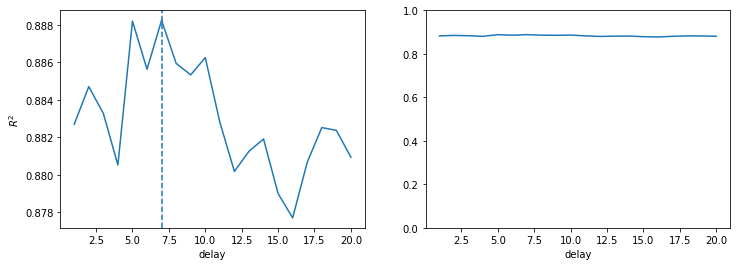

In [68]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [69]:
def linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; reg = []; score = []; coef_values = []
  # apply the model to each subrange
  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    lasso.fit(X_train, y_train)
    score_i = lasso.score(X_test, y_test)

    reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
    coef_values_i = reg_i.coef_
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    reg.append(reg_i)
    coef_values.append(coef_values_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef_values).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [70]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = [lasso.coef_[:-1] for lasso in m_k]
  coef_glob.append(np.asarray(coef_k).mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))                    # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [71]:
np.asarray(r_sq).mean()

0.8668505830944977

In [72]:
for r_i in r_sq:
  print(round(r_i, 2))

0.87
0.93
0.91
0.94
0.98
0.91
0.76
0.86
0.92
0.5
0.98
0.89
0.72
0.97


*Global* values for the coefficients of each policy type.

In [73]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.002147
Workplace closing                 -> 0.001505
Cancel public events              -> -0.002619
Restrictions on gatherings        -> -0.006235
Close public transport            -> -0.002250
Stay at home requirements         -> -0.003880
Restrictions on internal movement -> 0.002055
International travel controls     -> -0.000823
Public information campaigns      -> -0.000638
Facial Coverings                  -> -0.003569


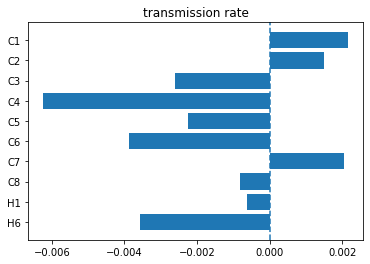

In [74]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

*Interval*-wise values for the coefficients of each policy type. They are meant to represent the coefficients at different stages of the pandemic.

In [75]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list...
n = len(coef_intv)         # fixed (no. countries)
m = np.zeros(n, dtype=int) # variable (no. intervals)
l = len(chx_str)           # fixed (no. policies)
for i in range(n):
  m[i] = len(coef_intv[i])

dim = m.max()
# ...and fill empty positions as NaN
for v in coef_intv:
  if(len(v) < dim):
    v += [[np.nan] * l] * (dim - len(v))

In [76]:
coef_intv = np.asarray(coef_intv)
print(coef_intv.shape)
coef_intv = coef_intv.mean(axis=0)
print(coef_intv.shape)

(14, 9, 10)
(9, 10)


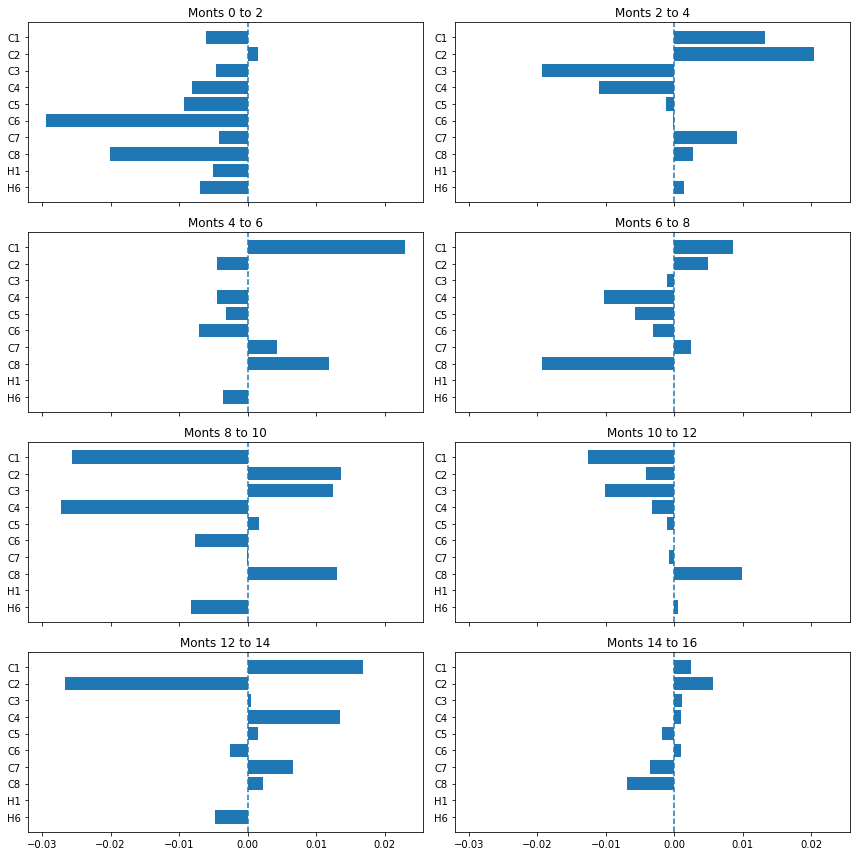

In [77]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))

n = 0
# don't use the last interval with less samples
for intv in coef_intv[:-1]:
  axs[n//2, n%2].barh(chx_str[::-1], intv[::-1]) # flip order
  axs[n//2, n%2].axvline(ls='--')
  axs[n//2, n%2].set_title('Monts {} to {}'.format(n*2, (n+1)*2))
  n += 1

fig.tight_layout()
fig.show()

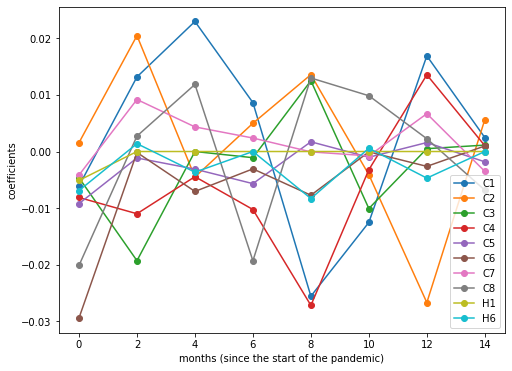

In [78]:
size_ratio = 1.25
plt.figure(figsize=[6.4*size_ratio, 4.8*size_ratio])
plt.plot(range(0, dim * 2, 2), coef_intv, 'o-')
plt.xlabel('months (since the start of the pandemic)')
plt.ylabel('coefficients')
plt.legend(chx_str)
plt.show()

In [79]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of single country model.

In [80]:
idx = -2 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : 0.018169
C2 : -0.003602
C3 : -0.022155
C4 : -0.001827
C5 : 0.000748
C7 : -0.004780
C8 : -0.000221
H1 : -0.001448
prev : 0.835225

R^2
---
0.72


Resulting predictions of the model.

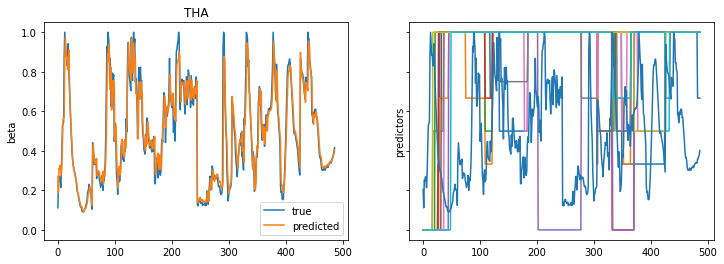

In [81]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

## Constrained model

Uses the transmission rate, $\beta$, as label. The coefficients (in every segment) are forced to take negative values.

In [82]:
# def constrained_model(region, delay=12, print=False):

### Non-negative least squares

This is achieved by reversing the sign of the coefficients, $\delta$, and imposing a positive constrain, namely $\delta \ge 0$.

Parameter grid search.

In [83]:
y_df = -beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = nnls(X.iloc[train_idx], y[train_idx])[0]
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.88560218, 0.88545714, 0.8853893 , 0.88544495, 0.88537138,
       0.88525994, 0.88487136, 0.88388877, 0.88397583, 0.88421684,
       0.88373442, 0.88355272, 0.88371683, 0.88366885, 0.88328288,
       0.88313158, 0.88311049, 0.88289975, 0.8831512 , 0.88303565])

In [84]:
cv_arr.mean()

0.8841381027928872

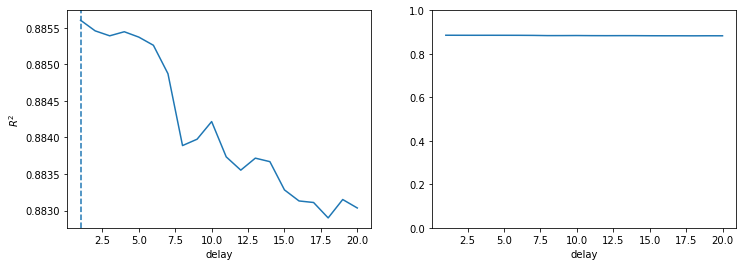

In [85]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [86]:
def nnls_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, -beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = nnls(X_train, y_train)[0]

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [87]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = nnls_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [88]:
np.asarray(r_sq).mean()

0.8782195806253486

In [89]:
for r_i in r_sq:
  print(round(r_i, 2))

0.87
0.91
0.91
0.93
0.97
0.92
0.74
0.85
0.91
0.72
0.98
0.88
0.74
0.96


*Global* values for the coefficients of each policy type.

In [90]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.001114
Workplace closing                 -> 0.003813
Cancel public events              -> 0.000963
Restrictions on gatherings        -> 0.001383
Close public transport            -> 0.000439
Stay at home requirements         -> 0.001371
Restrictions on internal movement -> 0.001608
International travel controls     -> 0.000988
Public information campaigns      -> 0.000164
Facial Coverings                  -> 0.000689


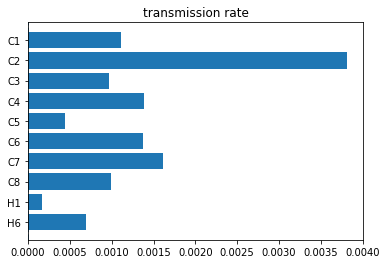

In [91]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

### Linear least-squares with bounds

This optimization problem is convex, hence a found **minimum** (if iterations have converged) is guaranteed to be **global**.

In [92]:
# bound policy coefficients (only)
bounds = (-np.inf, [0] * len(chx_str) + [np.inf])

In [93]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      # to do: use the last output of the function (success flag)
      # if(success == False): raise Exception
      fit = lsq_linear(X.iloc[train_idx], y[train_idx], bounds)['x']
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 8.85231087e-01,  8.84921507e-01,  8.85389301e-01,  8.85444949e-01,
        8.84589063e-01, -2.84326744e+19,  8.84871362e-01,  8.83700731e-01,
       -3.68671159e+19,  8.84218316e-01,  8.83734212e-01,  8.83552720e-01,
        8.83718122e-01,  8.83669174e-01,  8.83282882e-01,  8.83133067e-01,
        8.83110475e-01,  8.82735874e-01,  8.83109275e-01,  8.82667961e-01])

In [94]:
cv_arr.mean()

-3.264989516476746e+18

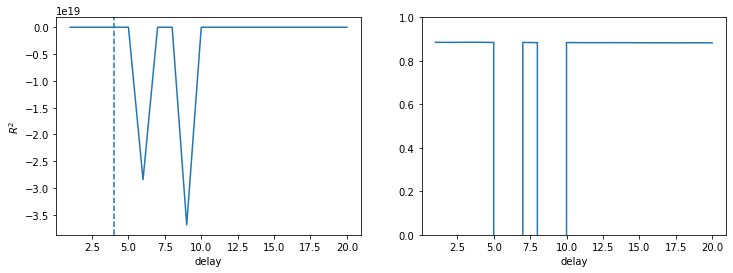

In [95]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [96]:
def lsq_linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = lsq_linear(X_train, y_train, bounds=bounds)['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [97]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = lsq_linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [98]:
np.asarray(r_sq).mean()

0.8782302762575996

In [99]:
for r_i in r_sq:
  print(round(r_i, 2))

0.87
0.91
0.91
0.93
0.97
0.92
0.74
0.85
0.91
0.72
0.98
0.88
0.74
0.96


In [100]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.002199
Workplace closing                 -> -0.002736
Cancel public events              -> -0.001575
Restrictions on gatherings        -> -0.005613
Close public transport            -> -0.025610
Stay at home requirements         -> -0.008647
Restrictions on internal movement -> -0.013470
International travel controls     -> -0.001231
Public information campaigns      -> -0.000494
Facial Coverings                  -> -0.009885


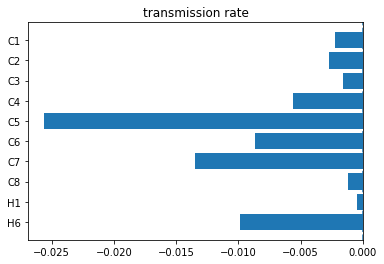

In [101]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

### Non-linear least-squares with bounds

Given the residuals `fun(x)` (an m-D real function of n real variables) and the (optional) loss function `rho(s)` (a scalar function), `least_squares` finds a **local minimum** of the cost function.

In [102]:
# initial guess on independent variables
x0 = [0] * len(chx_str) + [1]
# computes the vector of residuals
def fun(x, A, y):
  return A @ x - y

In [103]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      # to do: use the last output of the function (success flag)
      # if(success == False): raise Exception
      fit = least_squares(
          fun, x0, bounds=bounds, args=(X.iloc[train_idx], y[train_idx])
      )['x']
      kf_score = r2_score(y[test_idx], X.iloc[test_idx] @ fit)
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 0.44236378, -3.10779109,  0.88538919,  0.88544489,  0.66840194,
        0.88525977,  0.88487127,  0.88388878,  0.88397578,  0.88421752,
        0.88373453,  0.88355292,  0.88371824,  0.88366902,  0.88328324,
        0.88313175,  0.88311057,  0.88283563,  0.88310488,  0.87522281])

In [104]:
cv_arr.mean()

0.6510692708939823

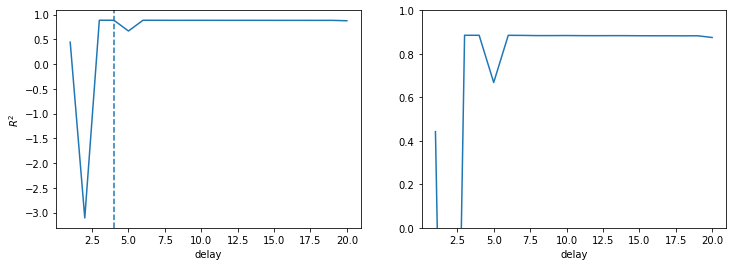

In [105]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [106]:
def least_squares_model(region, delay=12, print=False):
  '''Policy effect on cases based on constrained linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; score = []; coef = []
  # apply the model to each subrange
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    coef_i = least_squares(fun, x0, bounds=bounds, args=(X_train, y_train))['x']

    y_pred = X_test @ coef_i # matrix multiplication
    score_i = r2_score(y_true=y_test, y_pred=y_pred)
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    coef.append(coef_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return coef, X, y, score

In [107]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  c_k, X_k, y_k, r_k = least_squares_model(k)
  # each model is defined in segments (invervals)
  coef_k = np.asarray(c_k)[:, :-1]
  coef_glob.append(coef_k.mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))        # individual
  r_sq.append(r_k)

In [108]:
np.asarray(r_sq).mean()

0.878230830880791

In [109]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.001590
Workplace closing                 -> -0.002354
Cancel public events              -> -0.092759
Restrictions on gatherings        -> -0.094057
Close public transport            -> -3.004864
Stay at home requirements         -> -0.161600
Restrictions on internal movement -> -1.468430
International travel controls     -> -0.001223
Public information campaigns      -> -0.000481
Facial Coverings                  -> -0.051285


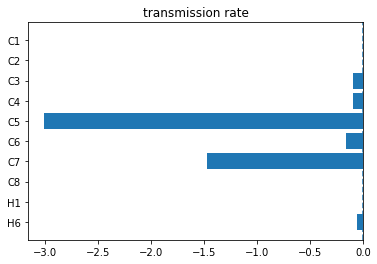

In [110]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

## Trials

Efficiency of applying weights to policy indicators in accordance to the proportion of the population who is affected by the policies.

In [111]:
tot_dict = {
    code: name for code, name in zip(
        oxcgrt_sub['CountryCode'].unique(), 
        oxcgrt_sub['CountryName'].unique()
    )
}
tot_dict['USA'] = 'US'
tot_dict

{'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'USA': 'US'}

In [112]:
sub_dict = {rc: rc.split('_')[0] for rc in oxcgrt_sub['RegionCode'].unique()}
for key in sub_dict.keys():
  # correct country codes
  sub_dict[key] = sub_dict[key].replace('BR', 'BRA')
  sub_dict[key] = sub_dict[key].replace('UK', 'GBR')
  sub_dict[key] = sub_dict[key].replace('US', 'USA')
sub_dict

{'BR_AC': 'BRA',
 'BR_AL': 'BRA',
 'BR_AM': 'BRA',
 'BR_AP': 'BRA',
 'BR_BA': 'BRA',
 'BR_CE': 'BRA',
 'BR_DF': 'BRA',
 'BR_ES': 'BRA',
 'BR_GO': 'BRA',
 'BR_MA': 'BRA',
 'BR_MG': 'BRA',
 'BR_MS': 'BRA',
 'BR_MT': 'BRA',
 'BR_PA': 'BRA',
 'BR_PB': 'BRA',
 'BR_PE': 'BRA',
 'BR_PI': 'BRA',
 'BR_PR': 'BRA',
 'BR_RJ': 'BRA',
 'BR_RN': 'BRA',
 'BR_RO': 'BRA',
 'BR_RR': 'BRA',
 'BR_RS': 'BRA',
 'BR_SC': 'BRA',
 'BR_SE': 'BRA',
 'BR_SP': 'BRA',
 'BR_TO': 'BRA',
 'CAN_AB': 'CAN',
 'CAN_BC': 'CAN',
 'CAN_MB': 'CAN',
 'CAN_NB': 'CAN',
 'CAN_NL': 'CAN',
 'CAN_NS': 'CAN',
 'CAN_NT': 'CAN',
 'CAN_NU': 'CAN',
 'CAN_ON': 'CAN',
 'CAN_PE': 'CAN',
 'CAN_QC': 'CAN',
 'CAN_SK': 'CAN',
 'CAN_YT': 'CAN',
 'CHN_AH': 'CHN',
 'CHN_BJ': 'CHN',
 'CHN_CQ': 'CHN',
 'CHN_FJ': 'CHN',
 'CHN_GD': 'CHN',
 'CHN_GS': 'CHN',
 'CHN_GX': 'CHN',
 'CHN_GZ': 'CHN',
 'CHN_HA': 'CHN',
 'CHN_HB': 'CHN',
 'CHN_HE': 'CHN',
 'CHN_HI': 'CHN',
 'CHN_HL': 'CHN',
 'CHN_HN': 'CHN',
 'CHN_JL': 'CHN',
 'CHN_JS': 'CHN',
 'CHN_JX': 'CHN',
 

In [113]:
for code, name in zip(oxcgrt_sub['RegionCode'].unique(), oxcgrt_sub['RegionName'].unique()):
  print(code, '<->', name)

BR_AC <-> Acre
BR_AL <-> Alagoas
BR_AM <-> Amazonas
BR_AP <-> Amapa
BR_BA <-> Bahia
BR_CE <-> Ceara
BR_DF <-> Distrito Federal
BR_ES <-> Espirito Santo
BR_GO <-> Goias
BR_MA <-> Maranhao
BR_MG <-> Minas Gerais
BR_MS <-> Mato Grosso do Sul
BR_MT <-> Mato Grosso
BR_PA <-> Para
BR_PB <-> Paraiba
BR_PE <-> Pernambuco
BR_PI <-> Piaui
BR_PR <-> Parana
BR_RJ <-> Rio de Janeiro
BR_RN <-> Rio Grande do Norte
BR_RO <-> Rondonia
BR_RR <-> Roraima
BR_RS <-> Rio Grande do Sul
BR_SC <-> Santa Catarina
BR_SE <-> Sergipe
BR_SP <-> Sao Paulo
BR_TO <-> Tocantins
CAN_AB <-> Alberta
CAN_BC <-> British Columbia
CAN_MB <-> Manitoba
CAN_NB <-> New Brunswick
CAN_NL <-> Newfoundland and Labrador
CAN_NS <-> Nova Scotia
CAN_NT <-> Northwest Territories
CAN_NU <-> Nunavut
CAN_ON <-> Ontario
CAN_PE <-> Prince Edward Island
CAN_QC <-> Quebec
CAN_SK <-> Saskatchewan
CAN_YT <-> Yukon
CHN_AH <-> Anhui
CHN_BJ <-> Beijing
CHN_CQ <-> Chongqing
CHN_FJ <-> Fujian
CHN_GD <-> Guangdong
CHN_GS <-> Gansu
CHN_GX <-> Guangxi
CHN

In [114]:
# https://worldpopulationreview.com/countries
tot_pop = {
    'BRA': 212559417,
    'CAN': 37742154,
    'CHN': 1439323776,
    'GBR': 67886011,
    'USA': 331002651
}

# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population
# https://worldpopulationreview.com/canadian-provinces
# https://en.wikipedia.org/wiki/List_of_Chinese_administrative_divisions_by_population
# https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom_by_population (2019)
# https://worldpopulationreview.com/states (2021)
sub_pop = {
    'BR_AC': 894470, 'BR_AL': 3351543, 'BR_AM': 4207714,
    'BR_AP': 861773, 'BR_BA': 14930634, 'BR_CE': 9187103,
    'BR_DF': 3055149, 'BR_ES': 4064052, 'BR_GO': 7113540,
    'BR_MA': 7114598, 'BR_MG': 21292666, 'BR_MS': 2809394,
    'BR_MT': 3526220, 'BR_PA': 8690745, 'BR_PB': 4039277,
    'BR_PE': 9616621, 'BR_PI': 3281480, 'BR_PR': 11516840,
    'BR_RJ': 17366189, 'BR_RN': 3534165, 'BR_RO': 1796460,
    'BR_RR': 631181, 'BR_RS': 11422973, 'BR_SC': 7252502,
    'BR_SE': 2318822, 'BR_SP': 46289333, 'BR_TO': 1590248,
    'CAN_AB': 4428112, 'CAN_BC': 5145851, 'CAN_MB': 1379584,
    'CAN_NB': 781315, 'CAN_NL': 520998, 'CAN_NS': 979115,
    'CAN_NT': 45074, 'CAN_NU': 39285, 'CAN_ON': 14733119,
    'CAN_PE': 159713, 'CAN_QC': 8575779, 'CAN_SK': 1177884,
    'CAN_YT': 42176, 'CHN_AH': 61027171, 'CHN_BJ': 21893095,
    'CHN_CQ': 32054159, 'CHN_FJ': 41540086, 'CHN_GD': 126012510,
    'CHN_GS': 25019831, 'CHN_GX': 50126804, 'CHN_GZ': 38562148,
    'CHN_HA': 99365519, 'CHN_HB': 57752557, 'CHN_HE': 74610235,
    'CHN_HI': 10081232, 'CHN_HL': 31850088, 'CHN_HN': 66444864,
    'CHN_JL': 24073453, 'CHN_JS': 84748016, 'CHN_JX': 45188635,
    'CHN_LN': 42591407, 'CHN_NM': 24049155, 'CHN_NX': 7202654,
    'CHN_QH': 5923957, 'CHN_SC': 83674866, 'CHN_SD': 101527453,
    'CHN_SH': 24870895, 'CHN_SN': 39528999, 'CHN_SX': 34915616,
    'CHN_TJ': 13866009, 'CHN_XJ': 25852345, 'CHN_XZ': 3648100,
    'CHN_YN': 47209277, 'CHN_ZJ': 64567588, 'UK_ENG': 56286961,
    'UK_NIR': 1893667, 'UK_SCO': 5463300, 'UK_WAL': 3152879	,
    'US_AK': 724357, 'US_AL': 4934193, 'US_AR': 3033946,
    'US_AZ': 7520103, 'US_CA': 39613493, 'US_CO': 5893634,
    'US_CT': 3552821, 'US_DC': 714153, 'US_DE': 990334,
    'US_FL': 21944577, 'US_GA': 10830007, 'US_HI': 1406430,
    'US_IA': 3167974, 'US_ID': 1860123, 'US_IL': 12569321,
    'US_IN': 6805663, 'US_KS': 2917224, 'US_KY': 4480713,
    'US_LA': 4627002, 'US_MA': 6912239, 'US_MD': 6065436,
    'US_ME': 1354522, 'US_MI': 9992427, 'US_MN': 5706398,
    'US_MO': 6169038, 'US_MS': 2966407, 'US_MT': 1085004,
    'US_NC': 10701022, 'US_ND': 770026, 'US_NE': 1951996,
    'US_NH': 1372203, 'US_NJ': 8874520, 'US_NM': 2105005,
    'US_NV': 3185786, 'US_NY': 19299981, 'US_OH': 11714618,
    'US_OK': 3990443, 'US_OR': 4289439, 'US_PA': 12804123,
    'US_RI': 1061509, 'US_SC': 5277830, 'US_SD': 896581,
    'US_TN': 6944260, 'US_TX': 29730311, 'US_UT': 3310774,
    'US_VA': 8603985, 'US_VT': 623251, 'US_WA': 7796941,
    'US_WI': 5852490, 'US_WV': 1767859, 'US_WY': 581075
}

In [115]:
sub_prop = {rc: sub_pop[rc] / tot_pop[cc] for rc, cc in sub_dict.items()}
sub_prop

{'BR_AC': 0.004208093965556934,
 'BR_AL': 0.015767558301121986,
 'BR_AM': 0.01979547205852564,
 'BR_AP': 0.004054268741243302,
 'BR_BA': 0.07024216668791484,
 'BR_CE': 0.043221340788679334,
 'BR_DF': 0.014373152895879461,
 'BR_ES': 0.019119604566849184,
 'BR_GO': 0.0334661249094412,
 'BR_MA': 0.03347110234123384,
 'BR_MG': 0.10017277192663734,
 'BR_MS': 0.013216982054481265,
 'BR_MT': 0.016589337935566505,
 'BR_PA': 0.04088619136549476,
 'BR_PB': 0.01900304892161047,
 'BR_PE': 0.04524203695948225,
 'BR_PI': 0.01543794222958374,
 'BR_PR': 0.05418174439196923,
 'BR_RJ': 0.08170039815267277,
 'BR_RN': 0.016626715719680395,
 'BR_RO': 0.008451566274290261,
 'BR_RR': 0.002969433247928037,
 'BR_RS': 0.053740140809663585,
 'BR_SC': 0.034119880936632416,
 'BR_SE': 0.010909053255448099,
 'BR_SP': 0.21777126439897979,
 'BR_TO': 0.007481428122283569,
 'CAN_AB': 0.1173253651606636,
 'CAN_BC': 0.13634227129696944,
 'CAN_MB': 0.036552868710143044,
 'CAN_NB': 0.020701388691276072,
 'CAN_NL': 0.0138041

In [116]:
# REPEAT COMPUTATION OF LABELS
cum_cases_alt = jhu_cases[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths_alt = jhu_death[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries_alt = jhu_recov[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()

R_alt = cum_deaths_alt + cum_recoveries_alt
I_alt = cum_cases_alt - R_alt
S_alt = tot_pop.values() - cum_cases_alt

i_prop_alt = I_alt / tot_pop.values()
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i_alt = np.log(i_prop_alt)
warnings.resetwarnings()
log_i_alt[np.isinf(log_i_alt)] = 0 # before the pandemic begins, the growth must be zero
gr_alt = log_i_alt[1:] - log_i_alt[:-1].values # different index
gr_alt

Country/Region,Brazil,Canada,China,United Kingdom,US
2020-01-23,0.000000,-19.055726,0.247127,0.000000,0.382992
2020-01-24,0.000000,0.510826,0.237200,0.000000,0.192372
2020-01-25,0.000000,0.538997,0.353038,0.000000,0.117783
2020-01-26,0.000000,0.405465,0.337818,0.000000,0.213574
2020-01-27,0.000000,0.287682,0.328822,0.000000,0.175891
...,...,...,...,...,...
2021-10-20,0.000560,0.001563,0.000362,0.005524,0.001603
2021-10-21,0.000562,0.001539,0.000378,0.005490,0.001598
2021-10-22,0.000325,0.000712,0.000186,0.003050,0.000842
2021-10-23,0.000336,0.000711,0.000200,0.002749,0.000824


Steps to apply the weights;
1. Pivot the original df and construct multilevel columns with region and country.
2. Convert to boolean type to obtain a binary representation.
3. Multiply by the proportional population
4. Stack the region column and group by date, which is equivalent to sum up the proportion of each region.

In [117]:
C1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[0])
C2_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[1])
C3_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[2])
C4_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[3])
C5_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[4])
C6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[5])
C7_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[6])
C8_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[7])
H1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[8])
H6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[9])

C1_bin = C1_sub.astype(bool) * sub_prop.values()
C2_bin = C2_sub.astype(bool) * sub_prop.values()
C3_bin = C3_sub.astype(bool) * sub_prop.values()
C4_bin = C4_sub.astype(bool) * sub_prop.values()
C5_bin = C5_sub.astype(bool) * sub_prop.values()
C6_bin = C6_sub.astype(bool) * sub_prop.values()
C7_bin = C7_sub.astype(bool) * sub_prop.values()
C8_bin = C8_sub.astype(bool) * sub_prop.values()
H1_bin = H1_sub.astype(bool) * sub_prop.values()
H6_bin = H6_sub.astype(bool) * sub_prop.values()

C1_weights = C1_bin.stack().groupby('Date').sum()
C2_weights = C2_bin.stack().groupby('Date').sum()
C3_weights = C3_bin.stack().groupby('Date').sum()
C4_weights = C4_bin.stack().groupby('Date').sum()
C5_weights = C5_bin.stack().groupby('Date').sum()
C6_weights = C6_bin.stack().groupby('Date').sum()
C7_weights = C7_bin.stack().groupby('Date').sum()
C8_weights = C8_bin.stack().groupby('Date').sum()
H1_weights = H1_bin.stack().groupby('Date').sum()
H6_weights = H6_bin.stack().groupby('Date').sum()

CH_w = [
        C1_weights, C2_weights, C3_weights, C4_weights, C5_weights,
        C6_weights, C7_weights, C8_weights, H1_weights, H6_weights
]

Comparison between the fits with and without applying weights.

In [118]:
def data_from_alt(iso, tr, t_d, y, weight):
  'Select data with location and time constraints.'

  if iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  t0 = cum_cases_alt.loc[cum_cases_alt[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases_alt[name] / tot_pop[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  if weight:
    # apply policy weights
    ch_w = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_w]
    w_t = pd.concat(ch_w, axis=1, ignore_index=True)
    pol_t *= w_t
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

In [119]:
def initial_model_weighted(region, tr=1, delay=12, weighted=True, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - weighted (bool) : wheter to apply weights to the policies.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from_alt(region, tr, delay, gr_alt, weighted)
  X, y = preprocess(X_raw, y_raw) 
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Don't apply weights

In [120]:
r_sq = [initial_model_weighted(k, weighted=False)[3] for k in tot_dict.keys()]
np.asarray(r_sq).mean()

0.3219739174867785

In [121]:
idx = 1 # country index
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, weighted=False, print=True)

Coefficients
------------
C1 : -0.035980
C3 : -0.027632
C4 : -0.013996
C7 : -0.050769
prev : 0.668227

R^2
---
0.884


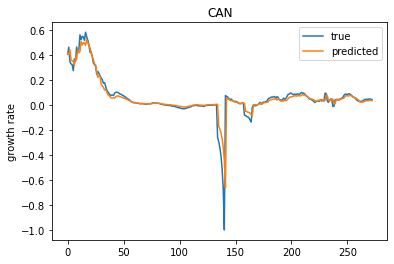

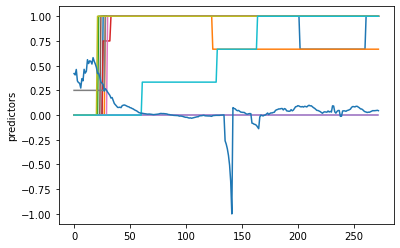

In [122]:
model, X, y = initial_model_weighted(cci, weighted=False)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

Apply weights

In [123]:
r_sq = [initial_model_weighted(k, weighted=True)[3] for k in tot_dict.keys()]
np.asarray(r_sq).mean()

0.4595575000318141

In [124]:
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, print=True)

Coefficients
------------
C1 : -0.032600
C3 : -0.022719
C4 : -0.075616
C6 : 0.006806
prev : 0.667573

R^2
---
0.885


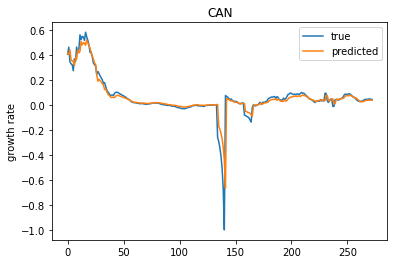

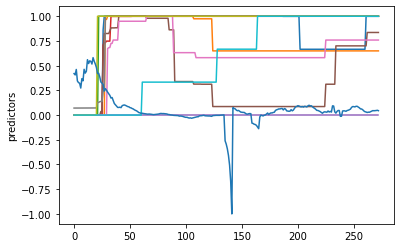

In [125]:
model, X, y = initial_model_weighted(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()